#**To categorize a user's gender we are going to deploy a classification model .**



#**Importing Necessary Libraries**

In [1]:
!pip install sentence-transformers

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import random
from google.colab import drive
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score,classification_report, precision_recall_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score



#**Data Loading**

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
flight=pd.read_csv("/content/drive/MyDrive/travel_capstone/flights.csv",on_bad_lines='skip')
hotel=pd.read_csv("/content/drive/MyDrive/travel_capstone/hotels.csv",on_bad_lines='skip')
user=pd.read_csv("/content/drive/MyDrive/travel_capstone/users.csv",on_bad_lines='skip')

## Dataset First view

In [15]:
flight.head()

,travelCode,userCode,from,to,flightType,price,time,distance,agency,date
0,0,0,Recife (PE),Florianopolis (SC),firstClass,1434.38,1.76,676.53,FlyingDrops,09/26/2019
1,0,0,Florianopolis (SC),Recife (PE),firstClass,1292.29,1.76,676.53,FlyingDrops,09/30/2019
2,1,0,Brasilia (DF),Florianopolis (SC),firstClass,1487.52,1.66,637.56,CloudFy,10/03/2019
3,1,0,Florianopolis (SC),Brasilia (DF),firstClass,1127.36,1.66,637.56,CloudFy,10/04/2019
4,2,0,Aracaju (SE),Salvador (BH),firstClass,1684.05,2.16,830.86,CloudFy,10/10/2019


In [16]:
hotel.head()

,travelCode,userCode,name,place,days,price,total,date
0,0,0,Hotel A,Florianopolis (SC),4,313.02,1252.08,09/26/2019
1,2,0,Hotel K,Salvador (BH),2,263.41,526.82,10/10/2019
2,7,0,Hotel K,Salvador (BH),3,263.41,790.23,11/14/2019
3,11,0,Hotel K,Salvador (BH),4,263.41,1053.64,12/12/2019
4,13,0,Hotel A,Florianopolis (SC),1,313.02,313.02,12/26/2019


In [17]:
user.head()

,code,company,name,gender,age
0,0,4You,Roy Braun,male,21
1,1,4You,Joseph Holsten,male,37
2,2,4You,Wilma Mcinnis,female,48
3,3,4You,Paula Daniel,female,23
4,4,4You,Patricia Carson,female,44


#**Data Preprocessing**

### Dataset Rows & Columns count

In [21]:
user.shape

(1340, 5)

### Checking Null Values for User Dataset



In [18]:
#check for missing values
user.isnull().sum()

,0
code,0
company,0
name,0
gender,0
age,0


In [19]:
#check for duplicate rows
user.duplicated().sum()

0

In [20]:
#check for data types of different features
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1340 entries, 0 to 1339
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   code     1340 non-null   int64 
 1   company  1340 non-null   object
 2   name     1340 non-null   object
 3   gender   1340 non-null   object
 4   age      1340 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 52.5+ KB


**Summary:-**
1. The gender feature, our dependent variable, will be encoded using a label encoder to convert its categorical values (i.e., male and female) into numeric representations suitable for the classification model. Here, 1 will denote male, and 0 will denote female.

2. The company feature holds a non-ordinal relationship, meaning the categories do not have a meaningful order. Therefore, using One-Hot Encoding is the best option to transform its categorical values into a numeric format suitable for the model.

3. For the name feature, we will apply an NLP model, such as a sentence transformer, to extract meaningful embeddings. Additionally, we will use PCA (Principal Component Analysis) to reduce dimensionality before using it in the classification model.

In [24]:
# 5 Point Summary of numerical features
user.describe()

,code,age
count,1340.000000,1340.000000
mean,669.500000,42.742537
std,386.968991,12.869779
min,0.000000,21.000000
25%,334.750000,32.000000
50%,669.500000,42.000000
75%,1004.250000,54.000000
max,1339.000000,65.000000


In [25]:
user.describe(include=['object', 'category'])

,company,name,gender
count,1340,1340,1340
unique,5,1338,3
top,4You,Charlotte Johnson,male
freq,453,2,452


In [26]:
user['company'].value_counts()

,count
company,
4You,453
Acme Factory,261
Wonka Company,237
Monsters CYA,195
Umbrella LTDA,194


In [28]:
user.sample(n=5)

,code,company,name,gender,age
987,987,Acme Factory,Chris Dougherty,none,40
866,866,Wonka Company,Yvonne Ahmad,female,46
109,109,4You,Maria Averitt,female,24
753,753,Wonka Company,Eric Capps,male,51
1270,1270,Umbrella LTDA,Christopher Wilkerson,none,47


In [29]:
user[user['name']=='Charlotte Johnson']

,code,company,name,gender,age
316,316,4You,Charlotte Johnson,female,64
496,496,Monsters CYA,Charlotte Johnson,none,51


In [30]:
# Summary of categorical features
user.describe(include=object)

,company,name,gender
count,1340,1340,1340
unique,5,1338,3
top,4You,Charlotte Johnson,male
freq,453,2,452


1. As we see ,we have 3 categories in our target variable ,let's deep dive into the target variable.


In [31]:
user['gender'].value_counts()

,count
gender,
male,452
female,448
none,440


In [32]:
#filtering records based on relavent categories in the target variable
user_df=user[(user['gender']=='male') | (user['gender']=='female') ]

In [33]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
one_hot_encoder = OneHotEncoder()

# One-Hot Encode the 'company' feature
company_encoded = one_hot_encoder.fit_transform(user_df[['company']]).toarray()

# Add one-hot encoded columns back to the DataFrame
company_encoded_df = pd.DataFrame(company_encoded, columns=one_hot_encoder.get_feature_names_out(['company']))
user_df = pd.concat([user_df, company_encoded_df], axis=1)

# Encode the 'gender' feature using Label Encoding
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
user_df['gender_encoded'] = label_encoder.fit_transform(user_df['gender'])


In [ ]:
# # Encode userCode and company to numeric values
# label_encoder = LabelEncoder()

# user_df['company_encoded'] = label_encoder.fit_transform(user_df['company'])
# user_df['gender_encoded'] = label_encoder.fit_transform(user_df['gender'])



In [34]:
user_df.head()

,code,company,name,gender,age,company_4You,company_Acme Factory,company_Monsters CYA,company_Umbrella LTDA,company_Wonka Company,gender_encoded
0,0.0,4You,Roy Braun,male,21.0,1.0,0.0,0.0,0.0,0.0,1
1,1.0,4You,Joseph Holsten,male,37.0,1.0,0.0,0.0,0.0,0.0,1
2,2.0,4You,Wilma Mcinnis,female,48.0,1.0,0.0,0.0,0.0,0.0,0
3,3.0,4You,Paula Daniel,female,23.0,1.0,0.0,0.0,0.0,0.0,0
4,4.0,4You,Patricia Carson,female,44.0,1.0,0.0,0.0,0.0,0.0,0


In [35]:
from sentence_transformers import SentenceTransformer
import pandas as pd

# Initialize the SentenceTransformer model
model = SentenceTransformer('flax-sentence-embeddings/all_datasets_v4_MiniLM-L6')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/7.34k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/535 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [37]:
# Handle missing values and ensure all are strings
text_columns = ['name']
for column in text_columns:
    user_df[column] = user_df[column].fillna('').astype(str)  # Replace NaN with empty string

# Encode text columns into embeddings
for column in text_columns:
    user_df[column + '_embedding'] = user_df[column].apply(lambda text: model.encode(text))

# Concatenate embeddings into a single feature vector (if required)
text_embeddings = user_df[[column + '_embedding' for column in text_columns]].values.tolist()


In [40]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# Update numerical features to include one-hot encoded company columns
numerical_features = ['code', 'age'] + [col for col in user_df.columns if col.startswith('company_')]

# Extract numerical features
X_numerical = user_df[numerical_features].values

# Apply PCA to text embeddings
n_components = 23  # Adjust the number of components as needed
pca = PCA(n_components=n_components)
text_columns = ['name']

# Create an empty array to store PCA-transformed embeddings
text_embeddings_pca = np.empty((len(user_df), n_components * len(text_columns)))

for i, column in enumerate(text_columns):
    embeddings = np.array(user_df[column + '_embedding'].tolist())
    embeddings_pca = pca.fit_transform(embeddings)
    text_embeddings_pca[:, i * n_components:(i + 1) * n_components] = embeddings_pca

# Combine PCA-transformed text embeddings and numerical features
X = np.hstack((text_embeddings_pca, X_numerical))

# Target variable
y = user_df['gender_encoded']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [41]:
len(text_embeddings)

1206

In [42]:
print("Shape of X:", X.shape)

Shape of X: (1206, 30)


In [43]:
user_df[numerical_features].values

array([[ 0., 21.,  1., ...,  0.,  0.,  0.],
       [ 1., 37.,  1., ...,  0.,  0.,  0.],
       [ 2., 48.,  1., ...,  0.,  0.,  0.],
       ...,
       [nan, nan,  0., ...,  0.,  1.,  0.],
       [nan, nan,  0., ...,  0.,  1.,  0.],
       [nan, nan,  0., ...,  0.,  1.,  0.]])

In [47]:
# Calculate missing values in percentage for training and test data
train_missing_percentage = pd.DataFrame(X_train).isnull().sum()/len(pd.DataFrame(X_train))*100
test_missing_percentage = pd.DataFrame(X_test).isnull().sum() * 100

print("Missing values in training data (percentage):\n", train_missing_percentage)
print("Missing values in test data (percentage):\n", test_missing_percentage)


Missing values in training data (percentage):
 0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
5     0.0
6     0.0
7     0.0
8     0.0
9     0.0
10    0.0
11    0.0
12    0.0
13    0.0
14    0.0
15    0.0
16    0.0
17    0.0
18    0.0
19    0.0
20    0.0
21    0.0
22    0.0
23    0.0
24    0.0
25    0.0
26    0.0
27    0.0
28    0.0
29    0.0
dtype: float64
Missing values in test data (percentage):
 0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
5     0.0
6     0.0
7     0.0
8     0.0
9     0.0
10    0.0
11    0.0
12    0.0
13    0.0
14    0.0
15    0.0
16    0.0
17    0.0
18    0.0
19    0.0
20    0.0
21    0.0
22    0.0
23    0.0
24    0.0
25    0.0
26    0.0
27    0.0
28    0.0
29    0.0
dtype: float64


In [46]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')  # You can also use 'median' or 'constant'
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)


#**Logistic Regression**

Accuracy: 0.9793388429752066

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.97        94
           1       0.97      0.98      0.97        97
           2       1.00      1.00      1.00        51

    accuracy                           0.98       242
   macro avg       0.98      0.98      0.98       242
weighted avg       0.98      0.98      0.98       242



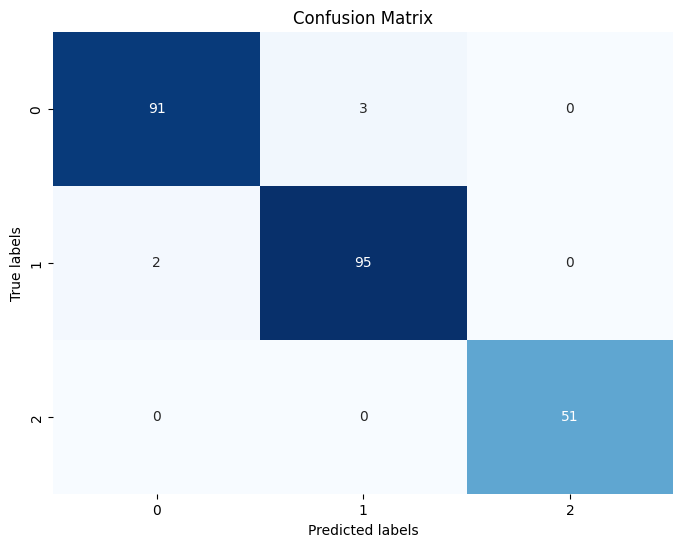

In [58]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer

# Impute missing values
imputer = SimpleImputer(strategy='median')  # You can adjust the strategy if needed
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Initialize and fit the Logistic Regression model
lr_classifier = LogisticRegression(random_state=42)
lr_classifier.fit(X_train, y_train)

# Predictions
y_pred_lr = lr_classifier.predict(X_test)

# Accuracy
accuracy = lr_classifier.score(X_test, y_test)
print("Accuracy:", accuracy)

# Classification report
report = classification_report(y_test, y_pred_lr)
print("\nClassification Report:\n", report)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_lr)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [55]:
from sklearn.impute import SimpleImputer

# Create an imputer to fill missing values with the median
imputer = SimpleImputer(strategy='median')

# Apply the imputer to both training and validation data
X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed = imputer.transform(X_val)

# Now train the model on the imputed data
lr_classifier.fit(X_train_imputed, y_train)

# Predictions on training and validation sets
y_train_pred = lr_classifier.predict(X_train_imputed)
y_val_pred = lr_classifier.predict(X_val_imputed)

# Calculate accuracy on training and validation sets
train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)

# Print the accuracies
print("Training Accuracy:", train_accuracy)
print("Validation Accuracy:", val_accuracy)

# Check if overfitting
if train_accuracy > val_accuracy:
    print("The model is overfitting.")
else:
    print("The model is not overfitting.")


Training Accuracy: 0.9699170124481328
Validation Accuracy: 0.9834710743801653
The model is not overfitting.


In [59]:
model_result = pd.DataFrame([['Logistic Regression Baseline', train_accuracy,val_accuracy]],
               columns = ['Model', 'Train accuracy', 'Validation accuracy'])

model_result

,Model,Train accuracy,Validation accuracy
0,Logistic Regression Baseline,0.969917,0.983471


#**Decision Tree Classifier**

Accuracy: 0.5702479338842975

Classification Report:
               precision    recall  f1-score   support

           0       0.39      0.19      0.26        94
           1       0.48      0.71      0.57        97
           2       1.00      1.00      1.00        51

    accuracy                           0.57       242
   macro avg       0.62      0.63      0.61       242
weighted avg       0.55      0.57      0.54       242



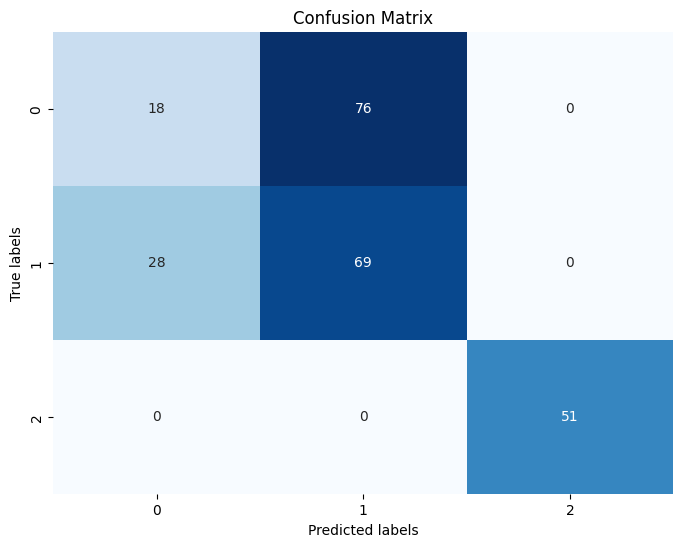

In [60]:
# Initialize a Random Forest Classifier
dt_classifier = DecisionTreeClassifier(random_state=42)

# Fit the model to the training data
dt_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred_dt = dt_classifier.predict(X_test)

# Calculate and print accuracy
accuracy = dt_classifier.score(X_test, y_test)
print("Accuracy:", accuracy)

# Generate a classification report
report = classification_report(y_test, y_pred_dt)
print("\nClassification Report:\n", report)

cm = confusion_matrix(y_test, y_pred_dt)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()



In [61]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model on the training set
dt_classifier.fit(X_train, y_train)

# Predictions on training and validation sets
y_train_pred = dt_classifier.predict(X_train)
y_val_pred = dt_classifier.predict(X_val)

# Calculate accuracy on training and validation sets
train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)

# Print the accuracies
print("Training Accuracy:", train_accuracy)
print("Validation Accuracy:", val_accuracy)

# Check if overfitting
if train_accuracy > val_accuracy:
    print("The model is overfitting.")
else:
    print("The model is not overfitting.")

Training Accuracy: 1.0
Validation Accuracy: 0.9586776859504132
The model is overfitting.


In [62]:
model = pd.DataFrame([['Decesion Tree Classifier Baseline', train_accuracy,val_accuracy]],
               columns = ['Model', 'Train accuracy', 'Validation accuracy'])
model_result = pd.concat([model_result,model],axis=0,ignore_index = True)
model_result

,Model,Train accuracy,Validation accuracy
0,Logistic Regression Baseline,0.969917,0.983471
1,Decesion Tree Classifier Baseline,1.000000,0.958678


#**Random Forest Classifier**

In [63]:
# Initialize a Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model to the training data
rf_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred_rf = rf_classifier.predict(X_test)

###**Evaluation**

Accuracy: 0.7644628099173554

Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.96      0.76        94
           1       0.96      0.98      0.97        97
           2       0.00      0.00      0.00        51

    accuracy                           0.76       242
   macro avg       0.53      0.65      0.58       242
weighted avg       0.63      0.76      0.68       242



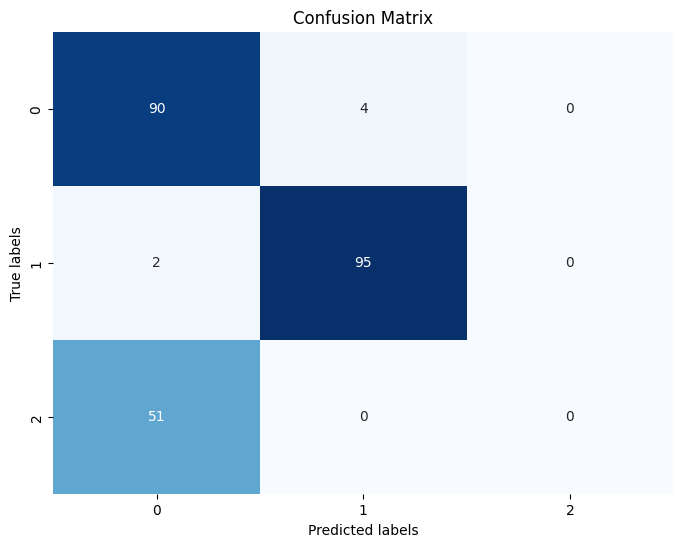

In [64]:
# Calculate and print accuracy
accuracy = rf_classifier.score(X_test, y_test)
print("Accuracy:", accuracy)

# Generate a classification report
report = classification_report(y_test, y_pred_rf)
print("\nClassification Report:\n", report)

cm = confusion_matrix(y_test, y_pred_rf)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()



In [65]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model on the training set
rf_classifier.fit(X_train, y_train)

# Predictions on training and validation sets
y_train_pred = rf_classifier.predict(X_train)
y_val_pred = rf_classifier.predict(X_val)

# Calculate accuracy on training and validation sets
train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)

# Print the accuracies
print("Training Accuracy:", train_accuracy)
print("Validation Accuracy:", val_accuracy)

# Check if overfitting
if train_accuracy > val_accuracy:
    print("The model is overfitting.")
else:
    print("The model is not overfitting.")

Training Accuracy: 1.0
Validation Accuracy: 0.9834710743801653
The model is overfitting.


In [66]:
model = pd.DataFrame([['Random Forest Baseline', train_accuracy,val_accuracy]],
               columns = ['Model', 'Train accuracy', 'Validation accuracy'])
model_result = pd.concat([model_result,model],axis=0,ignore_index = True)
model_result

,Model,Train accuracy,Validation accuracy
0,Logistic Regression Baseline,0.969917,0.983471
1,Decesion Tree Classifier Baseline,1.000000,0.958678
2,Random Forest Baseline,1.000000,0.983471


#**Gradient Boosting Classifier**

Accuracy: 0.9793388429752066

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.97        94
           1       0.98      0.97      0.97        97
           2       1.00      1.00      1.00        51

    accuracy                           0.98       242
   macro avg       0.98      0.98      0.98       242
weighted avg       0.98      0.98      0.98       242



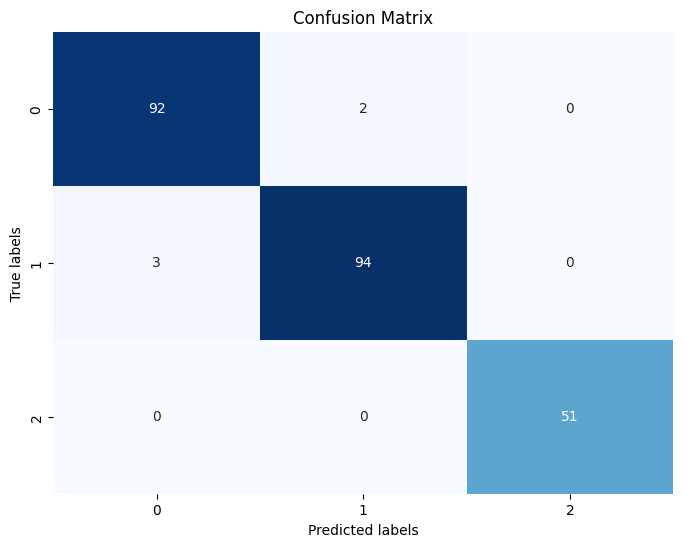

In [68]:
from sklearn.impute import SimpleImputer

# Initialize the imputer to fill NaN values with the mean of the column
imputer = SimpleImputer(strategy='mean')

# Fit the imputer and transform the training and test data
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Now fit the model with the imputed data
gb_classifier.fit(X_train_imputed, y_train)

# Make predictions and evaluate
y_pred_gb = gb_classifier.predict(X_test_imputed)
accuracy = gb_classifier.score(X_test_imputed, y_test)
print("Accuracy:", accuracy)

# Generate classification report
report = classification_report(y_test, y_pred_gb)
print("\nClassification Report:\n", report)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_gb)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [69]:
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split

# Initialize the imputer to fill NaN values with the mean of the column
imputer = SimpleImputer(strategy='mean')

# Impute missing values in the training and validation sets
X_imputed = imputer.fit_transform(X)

# Split the imputed data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

# Initialize the GradientBoostingClassifier
gb_classifier = GradientBoostingClassifier(n_estimators=100, random_state=42)

# Train the model on the training set
gb_classifier.fit(X_train, y_train)

# Predictions on training and validation sets
y_train_pred = gb_classifier.predict(X_train)
y_val_pred = gb_classifier.predict(X_val)

# Calculate accuracy on training and validation sets
train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)

# Print the accuracies
print("Training Accuracy:", train_accuracy)
print("Validation Accuracy:", val_accuracy)

# Check for overfitting
if train_accuracy > val_accuracy:
    print("The model is overfitting.")
else:
    print("The model is not overfitting.")


Training Accuracy: 1.0
Validation Accuracy: 0.9793388429752066
The model is overfitting.


In [70]:
model = pd.DataFrame([['XGBoost Classifier Baseline', train_accuracy,val_accuracy]],
               columns = ['Model', 'Train accuracy', 'Validation accuracy'])
model_result = pd.concat([model_result,model],axis=0,ignore_index = True)
model_result

,Model,Train accuracy,Validation accuracy
0,Logistic Regression Baseline,0.969917,0.983471
1,Decesion Tree Classifier Baseline,1.000000,0.958678
2,Random Forest Baseline,1.000000,0.983471
3,XGBoost Classifier Baseline,1.000000,0.979339


#**ROC-AUC Curve**

Now.... RF
Now.... GB
Now.... DT
Now.... Logistic Regression


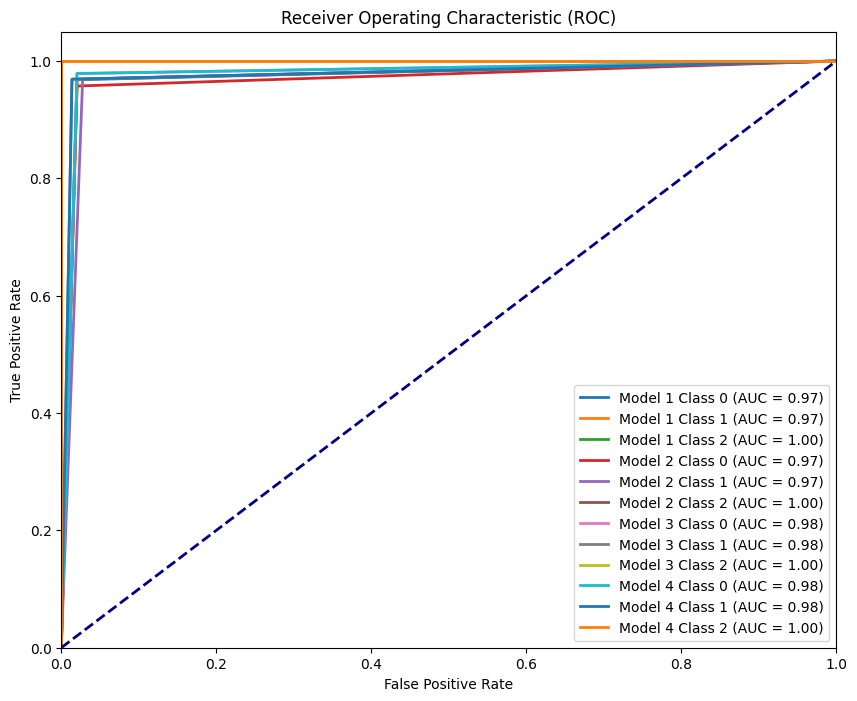

In [73]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import pandas as pd

# Function to train and evaluate the model
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    # Fit the model to the training data
    model.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Evaluate the model
    report = classification_report(y_test, y_pred)

    # Print accuracy and classification report
    #print(f"\nAccuracy for {model_name}: {accuracy:.2f}")
    #print(f"Classification Report for {model_name}:\n{report}")

    # Return accuracy, classification report, and predictions
    return accuracy, report, y_pred

# Initialize models
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
gradient_boosting = GradientBoostingClassifier(n_estimators=100, random_state=42)
decision_tree = DecisionTreeClassifier(random_state=42)
logistic_regression = LogisticRegression(random_state=42)

# Initialize imputer to handle missing values
imputer = SimpleImputer(strategy='mean')

# Impute missing values for training and test data
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Create a dictionary to store the classification reports and predictions
model_reports = {}

# Train and evaluate each model
print("Now.... RF")
accuracy, report, y_pred_rf = train_and_evaluate_model(random_forest, X_train_imputed, y_train, X_test_imputed, y_test, 'Random Forest')
model_reports['Random Forest'] = report

print("Now.... GB")
accuracy, report, y_pred_gb = train_and_evaluate_model(gradient_boosting, X_train_imputed, y_train, X_test_imputed, y_test, 'Gradient Boosting')
model_reports['Gradient Boosting'] = report

print("Now.... DT")
accuracy, report, y_pred_dt = train_and_evaluate_model(decision_tree, X_train_imputed, y_train, X_test_imputed, y_test, 'Decision Tree')
model_reports['Decision Tree'] = report

print("Now.... Logistic Regression")
accuracy, report, y_pred_lr = train_and_evaluate_model(logistic_regression, X_train_imputed, y_train, X_test_imputed, y_test, 'Logistic Regression')
model_reports['Logistic Regression'] = report

# Save the classification reports to a CSV file
reports_df = pd.DataFrame.from_dict(model_reports, orient='index', columns=['Classification Report'])
reports_df.to_csv('classification_reports.csv')

# Binarize the output labels for ROC curve calculation (multiclass case)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])  # Assuming three classes (0, 1, 2); modify if necessary

# Initialize lists to store fpr, tpr, and roc_auc for each model
fpr_list = []
tpr_list = []
roc_auc_list = []

# Compute ROC curve and ROC AUC for each model (for each class)
for y_pred in [y_pred_lr, y_pred_dt, y_pred_rf, y_pred_gb]:
    fpr = {}
    tpr = {}
    roc_auc = {}

    # For each class, calculate ROC curve and AUC
    for i in range(y_test_bin.shape[1]):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred == i)
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Store fpr, tpr, and roc_auc
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    roc_auc_list.append(roc_auc)

# Plot ROC curves for each model
plt.figure(figsize=(10, 8))
for i, roc_auc in enumerate(roc_auc_list):
    for j in roc_auc:
        plt.plot(fpr_list[i][j], tpr_list[i][j], lw=2, label=f'Model {i+1} Class {j} (AUC = {roc_auc[j]:0.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()


#**Benchmark Model Selection and Hyperparameter Tuning**

**Logistic Regression is our Benchmark model**

Best Hyperparameters: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Tuned Model Accuracy: 0.987603305785124

Tuned Model Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98        94
           1       0.98      0.99      0.98        97
           2       1.00      1.00      1.00        51

    accuracy                           0.99       242
   macro avg       0.99      0.99      0.99       242
weighted avg       0.99      0.99      0.99       242



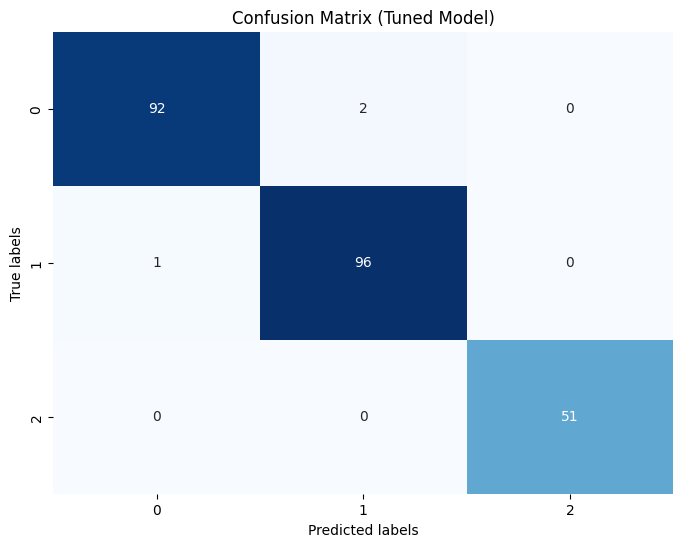

In [75]:
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Handle missing values by imputing with the mean value
imputer = SimpleImputer(strategy='median')

# Impute the training and testing data
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Now define the hyperparameters for tuning using GridSearchCV
param_grid = {
    'penalty': ['l1', 'l2'],  # Regularization penalty
    'C': [0.001, 0.01, 0.1, 1, 4, 100],  # Inverse of regularization strength
    'solver': ['liblinear', 'saga']  # Algorithm to use in the optimization problem
}

# Initialize Logistic Regression Classifier
lr_classifier = LogisticRegression(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(lr_classifier, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the GridSearchCV to the imputed training data
grid_search.fit(X_train_imputed, y_train)

# Print the best hyperparameters found
print("Best Hyperparameters:", grid_search.best_params_)

# Use the best model found by GridSearchCV
best_lr_classifier = grid_search.best_estimator_

# Make predictions on the imputed test data using the best model
y_pred_lr_tuned = best_lr_classifier.predict(X_test_imputed)

# Calculate and print accuracy using the best model
accuracy_tuned = best_lr_classifier.score(X_test_imputed, y_test)
print("Tuned Model Accuracy:", accuracy_tuned)

# Generate a classification report using the tuned model
report_tuned = classification_report(y_test, y_pred_lr_tuned)
print("\nTuned Model Classification Report:\n", report_tuned)

# Calculate confusion matrix using the tuned model
cm_tuned = confusion_matrix(y_test, y_pred_lr_tuned)

# Plot confusion matrix using the tuned model
plt.figure(figsize=(8, 6))
sns.heatmap(cm_tuned, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix (Tuned Model)')
plt.show()


In [76]:
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Handle missing values by imputing with the mean value
imputer = SimpleImputer(strategy='median')

# Impute the training and validation data
X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed = imputer.transform(X_val)

# Train the model on the imputed training set
best_lr_classifier.fit(X_train_imputed, y_train)

# Predictions on the imputed training and validation sets
y_train_pred = best_lr_classifier.predict(X_train_imputed)
y_val_pred = best_lr_classifier.predict(X_val_imputed)

# Calculate accuracy on the training and validation sets
train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)

# Print the accuracies
print("Training Accuracy:", train_accuracy)
print("Validation Accuracy:", val_accuracy)


Training Accuracy: 0.9761410788381742
Validation Accuracy: 0.987603305785124


#**Pickle the Benchmark model**

In [77]:
import pickle

# Pickle the tuned logistic regression model
with open('tuned_logistic_regression_model.pkl', 'wb') as file:
    pickle.dump(best_lr_classifier, file)


In [78]:
# Pickle the Scaler model
with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

In [79]:
# Pickle the PCA model
with open('pca.pkl', 'wb') as file:
    pickle.dump(pca, file)